# Import

In [37]:
from typing_extensions import ParamSpecArgs
import os
from typing import Optional

import numpy as np
import random

import gym
from gym import spaces
from gym.error import DependencyNotInstalled
from collections import defaultdict
from Strategy import basic_strategy

# Environment Modification

In [33]:
def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21

def usable_split(hand):
    return (len(hand) == 2 and hand[0] == hand[1])


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]



# this is a helper function we need for the mote_carlo_ES function
def ES_Greedy(action, n_actions, epsilon=0.3):
    '''
    This function takes the best estimated action, eplsilon, and action space
    and returns some action.
    '''
    n = np.random.rand(1) # generate a random number from 0 to 1.

    if n >= 1-epsilon: # take random action in this case, otherwise take the suggested
      action = np.random.randint(n_actions)
    return action


action_space = [0,1,2,3]

class BlackjackEnv(gym.Env):

  metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
    }

  def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
      global action_space

      self.observation_space = spaces.Tuple(
          (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2), spaces.Discrete(2))
      )

      self.natural = natural

      self.sab = sab

      self.render_mode = render_mode

      self.splitted = False


  def _get_obs(self):
    return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), usable_split(self.player))

  def step(self, action):
    global action_space

    if (action == 0):

      terminated = True
      while sum_hand(self.dealer) < 17:
          self.dealer.append(draw_card(self.np_random))
      reward = cmp(score(self.player), score(self.dealer))
      if self.sab and is_natural(self.player) and not is_natural(self.dealer):
          # Player automatically wins. Rules consistent with S&B
          reward = 1.0
      elif (
          not self.sab
          and self.natural
          and is_natural(self.player)
          and reward == 1.0
      ):
          # Natural gives extra points, but doesn't autowin. Legacy implementation
          reward = 1.5

    elif (action == 1):

      #print("hit and change self.player")
      self.player.append(draw_card(self.np_random))

      if (is_bust(self.player)):
          terminated = True
          reward = -1.0
      else:
          terminated = False
          reward = 0.0

      #print("reward")

    elif (action == 2):

      self.player.append(draw_card(self.np_random))
      terminated = True
      while sum_hand(self.dealer) < 17:
          self.dealer.append(draw_card(self.np_random))
      #double the reward
      reward = 2*cmp(score(self.player), score(self.dealer))
      if self.sab and is_natural(self.player) and not is_natural(self.dealer):
          # Player automatically wins. Rules consistent with S&B
          reward = 2.0
      elif (
          not self.sab
          and self.natural
          and is_natural(self.player)
          and reward == 2.0
      ):
          # Natural gives extra points, but doesn't autowin. Legacy implementation
          reward = 3


    #action == 3
    else:
      #call the step function itself
      dealer_up = self.dealer[0]
      #print("action 3")
      total_reward = []

      for i in range(2):
        hand = [self.player[0], draw_card(self.np_random)]
        self.player = hand
        self.dealer[0] = dealer_up
        state = self._get_obs()

        # check if a policy for the state exists
        if (usable_split(self.player)):
          action_space = [0,1,2,3]
        else:
          action_space = [0,1,2]
        #print("self.action_space: ", self.action_space)

        if isinstance(policy[state], np.int64):
          # obtain action from policy
          # print(f"isinstance {state}, {policy[state]}")
          action2 = ES_Greedy(round(policy[state]), len(action_space), epsilon = 0.5)

        else:
          action2 = np.random.randint(len(action_space))

        #action use the global greedy_epislon function
        #and make the policy a global variable that is updated throug the problems
        #print("action 2: ", action2)
        obs, rwd, terminated, info = self.step(action2)
        #print("steped")

        total_reward.append(rwd)
      sorted_total_reward = sorted(total_reward, reverse = True)
      total_weighted_reward = 2*(0.7*sorted_total_reward[0]+0.3*sorted_total_reward[1])
      # sum_reward = sorted_total_reward[0]+sorted_total_reward[1]
      # avg_reward = 0.5*(sorted_total_reward[0]+sorted_total_reward[1])
      reward = total_weighted_reward

    return self._get_obs(), reward, terminated, False


  def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):

    global action_space
    super().reset(seed=seed)
    self.dealer = draw_hand(self.np_random)
    self.player = draw_hand(self.np_random)

    _, dealer_card_value, _ , _  = self._get_obs()

    suits = ["C", "D", "H", "S"]
    self.dealer_top_card_suit = self.np_random.choice(suits)

    if dealer_card_value == 1:
        self.dealer_top_card_value_str = "A"
    elif dealer_card_value == 10:
        self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
    else:
        self.dealer_top_card_value_str = str(dealer_card_value)

    if self.render_mode == "human":
        self.render()

    if (usable_split(self.player)):
      action_space = [0,1,2,3]
    else:
      action_space = [0,1,2]


    return self._get_obs(), {}

In [2]:
# Make policy a global variable
policy = defaultdict(float)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Helper Functions
Since this time we have several global variables, we might need helper function in there instead of wrapped in some helper file. Let's explicitly define those.

In [3]:
def get_total(Input):
    """
    This function will calculate the maximum total of a hand in 21.
    It will also take into consideration if the Deck has aces.

    Returns:
    Maxmum value of a deck of card
    Args:
    Input:List of numbers representing  a hand

    """
    Input = np.array(Input) # maximum player hand under or equal to 21
    Max = 0

    # check if the hand has an ace
    if 1 in set(Input):

        # put all aces in one array and all other cards in a second array
        aces = Input[Input==1]
        not_aces=Input[Input!=1]

        # try different posable combinations of aces as 1 or 11
        for ace in range(len(aces)+1):
            # convert each  ace to an 11
            aces[0:ace] = 11
            # find the total of a particular combination
            total = aces.sum()+not_aces.sum()
            # check if the total is 21
            if total == 21:
                Max = 21
                break
            # check if the total is larger than Max value but less than 22

            elif total>Max and total<22:
                # if so total is new max
                Max = total

    else:
        # determine  sum if no aces in the deck
        Max=sum(Input)

    return Max

In [4]:
def game_result (environment,state,show=True):
    '''
    this function  will determine the results of  a game  of Black Jack after an episode only  tested for open AI  gym
    Returns:
    result:   used to debug result of a game like open AI  gym +1,drawing is 0, and losing is -1, None for error
    Args:
    environment: open ai gym black jack environment
    state: state of open ai gym black jack environment
    '''
    if show:
        print(f"state: {state}")
        print(f"player has {environment.player}")
        print(f"the players current sum:{state[0]}, dealer's one showing card:{state[1]}, usable ace:{state[2]}")
    dealer_sum = get_total(environment.dealer)
    result = None
    if show:
        print(f"dealer cards: {environment.dealer}, dealer score: {dealer_sum}")
        print(f"your score: {state[0]}")

    if state[0] > 21:
        if show:
            print("Bust")
        result = -1
    elif dealer_sum > 21:

        if show:
            print("agent wins :)")
        result = 1

    elif state[0]>dealer_sum and state[0]<22:
        if show:
            print("agent wins :)")
        result = 1

    elif  state[0]<dealer_sum and dealer_sum<22 :
        if show:
            print("agent loses :(")
        result = -1
    return result

In [5]:
def average_wins(environment, policy, episodes=10):
    '''
    This function calculates the average number of wins for a game of blackjack given a policy.
    If no policy is provided a random policy is selected.
    Args:
      environment:AI gym balckjack envorment object
      policy:policy for blackjack if none a random  action will be selected
      episodes: number of episodes
    Returns:
      average_wins: the average number of wins
      std_wins: the average number of wins
    '''
    global action_space
    win_loss = np.zeros(episodes)

    #global policy

    for episode in range(episodes):
        state = environment.reset()[0]
        done = False

        while not done:

          if policy == "random":
            action = random.sample(action_space, 1)
            # print(f"action: {action}")

          else:
            if isinstance(policy[state], np.int64):
                action = policy[state]

            else:
                action = random.sample(action_space,1) # check back later (!!)

          state, reward, done, info = environment.step(action)
          result = game_result(environment, state, show=False)

          if reward > 0:
              win_loss[episode] = 1 # win
          else:
              win_loss[episode] = 0 # lose

    # compute the average wins and the standard deviation
    average_wins = win_loss.mean()
    std_win = win_loss.std()/np.sqrt(episodes)

    return average_wins ,std_win

# Method


In [6]:
environment = BlackjackEnv()

In [7]:
from collections import defaultdict


def monte_carlo_ES(environment, N_episodes=100000, discount_factor=1, epsilon=0.1, theta=0.0001):
    '''
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    Args:
        environment: OpenAI gym environment.
        N_episodes: Number of episodes. Integer value.
        discount_factor: Gamma discount factor. Float betwen 0 and 1.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        theta: stoping threshold
    Returns:
        policy: a dictionary of estimated policy for blackjack
        V: a dictionary of estimated values for blackjack
        Q: a dictionary of estimated action function
        DELTA: list of deltas for each episode
    '''
    # initializations (defaultdict to avoid potential key error)
    global policy
    global action_space
    V = defaultdict(float) # estimated values for blackjack
    Q = defaultdict(float) # estimated action function for blackjack
    Counter_Visits= defaultdict(float) # number of visits to action function
    Counter_VisitsValue = defaultdict(float) # number of visits to the action function (increment mean)
    DELTA = [] # list of max difference between value functions per iteration
    # n = environment.action_space.n
    # len(environment.action_space)

    for i in range(N_episodes):

        delta = 0 # item in DELTA (i.e. max difference between value functions)
        episode = [] # stores each state and reward for each episode

        # reset each episode
        state = environment.reset()
        #print("state: ", state)
        #print("action_space: ", environment.action_space)
        reward = 0.0
        done = False
        action = np.random.randint(len(action_space)) # action for the first state
        episode.append({'state':state , 'reward':reward, 'action':action}) # append first state, reward and action

        # enumerate for each episode
        while not done:

            # take action and find next state, reward and check if the episode is done (True)
            (state, reward, done, prob) = environment.step(action)

            # check if a policy for the state exists
            if isinstance(policy[state], np.int64):
                # obtain action from policy
                # print(f"isinstance {state}, {policy[state]}")
                if ((state[-1])):
                  action_space = [0,1,2,3]
                else:
                  action_space = [0,1,2]
                #print("action_space: ", action_space)
                action = ES_Greedy(action = round(policy[state]), n_actions = len(action_space), epsilon=epsilon) # call ES_Greedy function
            else:
                if ((state[-1])):
                  action_space = [0,1,2,3]
                else:
                  action_space = [0,1,2]
                #print("action_space: ", action_space)
                # if no policy for the state exists select a random action
                action = np.random.randint(len(action_space))
                # print(policy[state])

            # add state reward and action to list
            episode.append({'state':state, 'reward':reward, 'action':action})

        episode.reverse() # reverse list as the return is calculated from the last state

        # initialize the expected total discount reward
        G = 0

        for t,step in enumerate(episode):
            #print("episode: ", i)
            G = discount_factor*G + step['reward']
            #print("step: ", step)
            #print("len_state: ", len(step['state']))
            if (len(step['state']) == 2): #it means its structure is (state,{})
              state = step['state'][0]
            else: #it means its structure is (state)
              state = step['state']
            Counter_Visits[state, step['action']] += 1 # increment counter for action
            Counter_VisitsValue[state] += 1  # increment counter for value function
            #print("vists, values: ")
            #print(Counter_Visits, Counter_VisitsValue)
            #print("state: ", state)
            # if the action function value does not exist, create an array to store them
            if not isinstance(Q[state],np.ndarray):
                if ((state[-1])):
                  action_space = [0,1,2,3]
                else:
                  action_space = [0,1,2]
                Q[state]= np.zeros(len(action_space))

            # calculate mean of action function Q Value functions V using the recursive definition of mean
            #print("state ", state)
            #print("Q: ", Q)
            #print("Q[state] ", Q[state])
            #print("action " , step['action'])
            #print("Q_s_a ", Q[state][step['action']])
            Q_s_a = Q[state][step['action']]
            Q[state][step['action']] += (Counter_Visits[state, step['action']]**-1)*(G-Q_s_a) #First Visit implementation

            # record the old value of the value function
            v = V[state]
            V[state] += (Counter_VisitsValue[state]**-1)*(G-v)

            # update the policy to select the action fuciton argment with the largest value
            policy[state] = np.random.choice(np.where(Q[state] == Q[state].max())[0])

            # find max difference between all value functions per iteration
            delta = max(delta,abs(v-V[state]))

        DELTA.append(delta)
        #print(state)
        # print(DELTA) # for debug purpose, get rid off later
        if delta < theta:
            break

    return policy, V, Q, DELTA, Counter_Visits

In [11]:
policy, V, Q, DELTA, Counter_Visits= monte_carlo_ES(environment, N_episodes=100000, discount_factor= 0.9, epsilon = 0.5, theta=-1)

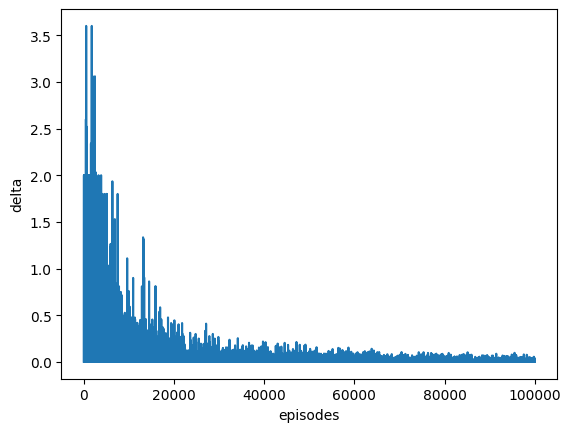

In [12]:
import matplotlib.pyplot as plt

plt.plot(DELTA)
plt.xlabel("episodes")
plt.ylabel("delta")
plt.show()

In [13]:
# See outputs
from itertools import filterfalse, islice


print("====================== DELTA ======================")
print(DELTA[10000: 10005])
print("\n======================== V ========================")
for state, value in islice(V.items(), 5):
    print(f"State: {state}, Value: {value}")
print("\n======================== Q ========================")
for state, value in islice(Q.items(), 5):
    print(f"State: {state}, Value: {value}")
print("\n===================== Policy ======================")
for state, value in islice(policy.items(), 5):
    print(f"State: {state}, Value: {value}")

====================== DELTA ======================
[0.01160526315789473, 0.006873168316831657, 0.0007838827838827778, 0.05382575757575758, 0.011720437457279562]

======================== V ========================
State: (27, 4, False, False), Value: -1.1276595744680857
State: (19, 4, False, False), Value: 0.18506659729448494
State: (19, 7, False, False), Value: 0.2946456692913379
State: (14, 7, False, False), Value: -0.477448882410107
State: (15, 10, False, False), Value: -0.6948546578164357

======================== Q ========================
State: (27, 4, False, False), Value: [-1.31034483 -1.09122807 -1.10222222]
State: (19, 4, False, False), Value: [ 0.52394366 -0.30023077 -0.06666667]
State: (19, 7, False, False), Value: [ 0.75537367 -0.33680672 -0.20833333]
State: (14, 7, False, False), Value: [-0.47651007 -0.47290738 -0.4817734 ]
State: (15, 10, False, False), Value: [-0.67447241 -0.67281867 -0.75091674]

===================== Policy ======================
State: (21, 7, True

In [14]:
average, std_win = average_wins(environment, policy, episodes=500000)
print("average wins:", average, std_win)

average wins: 0.422242 0.000698503677064051


## Tune

In [15]:
# tuning hyperparameters
## episode length
accuracy1 = []
episodes = []

for n_episode in [1,50,100,500,1000,5000,10000,50000,100000]:
    print("n_episode: ", str(n_episode))
    policy, V, Q, DELTA, Counter_Visits = monte_carlo_ES(environment, N_episodes=n_episode, discount_factor=1, theta = -1)
    average, std_win = average_wins(environment, policy, episodes=100000)
    print("n_episode: ", str(n_episode), " average: ", str(average))
    accuracy1.append(average)
    episodes.append(n_episode)

n_episode:  1
n_episode:  1  average:  0.42419
n_episode:  50
n_episode:  50  average:  0.38606
n_episode:  100
n_episode:  100  average:  0.35054
n_episode:  500
n_episode:  500  average:  0.34856
n_episode:  1000
n_episode:  1000  average:  0.35712
n_episode:  5000
n_episode:  5000  average:  0.39554
n_episode:  10000
n_episode:  10000  average:  0.40332
n_episode:  50000
n_episode:  50000  average:  0.41963
n_episode:  100000
n_episode:  100000  average:  0.41919


In [16]:
## discount factor
accuracy2=[]
discounts=[]

for discount in [0,0.01,0.1,0.5,0.7,1.0]:
    policy, V, Q, DELTA, Counter_Visits = monte_carlo_ES(environment, N_episodes=100000, discount_factor=discount, epsilon=0.5, theta=-1)
    average, std_win=average_wins(environment, policy, episodes=100000)
    print("discount: ", str(discount), " average: ", str(average))
    discounts.append(discount)
    accuracy2.append(average)

discount:  0  average:  0.30837
discount:  0.01  average:  0.28573
discount:  0.1  average:  0.32193
discount:  0.5  average:  0.41695
discount:  0.7  average:  0.42242
discount:  1.0  average:  0.42063


In [17]:
## epsilon
accuracy3=[]
epsilons=[]

for es in [0,0.01,0.1,0.3,0.5,0.7]:
    policy, V, Q, DELTA, Counter_Visits = monte_carlo_ES(environment, N_episodes=100000, discount_factor=1, epsilon=es, theta=-1)
    average, std_win = average_wins(environment, policy, episodes=100000)
    print("epsilon: ", str(es), " average: ", str(average))
    epsilons.append(es)
    accuracy3.append(average)

epsilon:  0  average:  0.41955
epsilon:  0.01  average:  0.42427
epsilon:  0.1  average:  0.42173
epsilon:  0.3  average:  0.42287
epsilon:  0.5  average:  0.41879
epsilon:  0.7  average:  0.41972


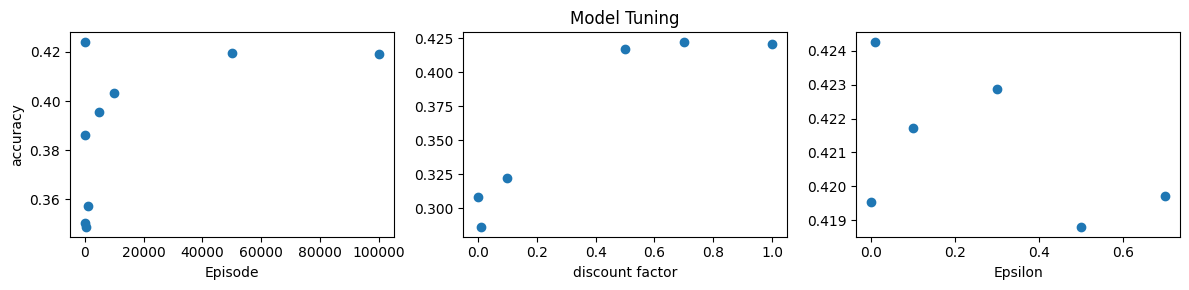

In [18]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3))
ax[0].scatter(episodes, accuracy1)
ax[1].scatter(discounts, accuracy2)
ax[2].scatter(epsilons, accuracy3)

ax[0].set(xlabel = "Episode",
          ylabel = "accuracy")
ax[1].set(title = "Model Tuning",
          xlabel = "discount factor")
ax[2].set(xlabel = "Epsilon")

plt.tight_layout()

In [19]:
policy, V, Q, DELTA, Counter_Visits= monte_carlo_ES(environment, N_episodes=100000, discount_factor= 1, epsilon = 0.3, theta=-1)

In [20]:
average, std_win = average_wins(environment, policy, episodes=100000)
print("average wins:", average, std_win)

average wins: 0.42314 0.00156234612170287


In [21]:
def plot_policy_blackjack(policy):
    '''
    plot the policy for blackjack
    Args:
      policy: a dictionary of estimated values for blackjack
    Returns:  N/A
    '''
    # range of player score
    player = [state[0] for state in policy.keys()]
    max_player = max(player)
    min_player = min(player)

    player_range = np.arange(min_player, 22, 1) # min_player=12 based on the environment set up

    # range of dealer score
    dealer = [state[1]  for state in policy.keys()]
    max_dealer = max(dealer)
    min_dealer = min(dealer)
    dealer_range = np.arange(min_dealer, 11, 1)

    # empty array for the value function
      # first access in the players score
      # second is the dealer,
      # third is if there is an ace
    policy_plot = np.zeros((21-min_player+1, max_dealer-min_dealer+1, 2))

    # create a mesh grid for plotting
    X,Y = np.meshgrid(dealer_range,player_range)


    # populate an array  of values for different  policy not including losing states above 21
    for (player,dealer,ace,split,twocards),v in policy.items():
        if player<=21 and dealer<=10 and player>=min_player:
            policy_plot[player-min_player,dealer-min_dealer,(1*ace)] = policy[(player, dealer, ace)]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
    ax[0].imshow((policy_plot[:,:,0]),cmap=plt.get_cmap('inferno', 2),extent =[1,10,21,4])
    ax[0].set_title('no ace (hard)')
    ax[0].set_xlabel('dealer')
    ax[0].set_ylabel('player')
    ax[0].invert_yaxis()

    ax[1].set_title('with ace (soft)')
    ax[1].set_xlabel('dealer')
    ax[1].imshow(policy_plot[:,:,1],cmap=plt.get_cmap('inferno', 2), extent =[1,10,21,4])
    # fig.colorbar(im, ax=ax[1], ticks=[0 , 1])
    # plt.gca().invert_yaxis()
    ax[1].invert_yaxis()

In [22]:
split_states = []
for state in policy.keys():
  split = state[-1]
  if split:
    split_states.append(state)

In [23]:
player_hand = []
dealer_up = []
action = []
usable_ace = []
heat_data = []

for s in split_states:
  player_hand.append(s[0])
  dealer_up.append(s[1])
  usable_ace.append(s[2])
  action.append(policy[s])

  heat_data.append([s[0],s[1],s[2], policy[s]])


In [25]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(heat_data)
df.columns = ["player hand", "dealer", "usable_ace", "action"]

In [26]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,player hand,dealer,usable_ace,action
0,18,1,False,3
1,12,10,False,0
2,18,6,False,3
3,20,2,False,0
4,20,10,False,0
...,...,...,...,...
95,14,8,False,2
96,16,1,False,1
97,18,4,False,3
98,4,4,False,3


In [27]:
df[df["action"] == 3]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,player hand,dealer,usable_ace,action
0,18,1,False,3
2,18,6,False,3
5,14,3,False,3
6,14,10,False,3
11,18,2,False,3
17,12,5,False,3
19,8,2,False,3
20,4,7,False,3
21,16,10,False,3
28,12,10,True,3


In [28]:
df[(df["player hand"] == 12) & (df["usable_ace"] == True)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,player hand,dealer,usable_ace,action
28,12,10,True,3
32,12,8,True,3
40,12,6,True,3
48,12,4,True,3
56,12,2,True,2
64,12,5,True,3
75,12,3,True,3
76,12,1,True,3
77,12,7,True,3
80,12,9,True,3


In [29]:
df[df["player hand"] == 4]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,player hand,dealer,usable_ace,action
20,4,7,False,3
24,4,3,False,1
26,4,8,False,1
29,4,9,False,3
30,4,10,False,1
31,4,2,False,1
60,4,5,False,3
71,4,1,False,1
82,4,6,False,3
98,4,4,False,3


In [30]:
Counter_Visits[(10,4,False,True,True), 1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0

In [36]:
basic_strategy_dict = basic_strategy
average, std_win = average_wins(environment, basic_strategy_dict, episodes=100000)
print("average wins:", average, std_win)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


average wins: 0.45532 0.0015748133146503429
